In [62]:
import keras
import numpy
import matplotlib.pyplot as plt
import os
import random
import tensorflow

from keras import backend as K
from keras.datasets import mnist
from keras.engine.topology import Layer
from keras.layers import Activation, Dense, Input, Lambda
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.losses import binary_crossentropy, mean_squared_error
from keras.models import Model
from PIL import Image
from sklearn.mixture import GaussianMixture
from scipy.stats import mode

numpy.random.seed(42)

# Network parameters
batch_size = 128
num_epochs = 30
kernel_size = 4
latent_dims = [32]
strides=2
layer_filters = [32, 64]

# mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

def preprocess(data):
    if data.ndim == 3:
        data = numpy.asarray([data]).transpose((1, 2, 3, 0))
    maxima = data.max(axis=tuple(range(1, data.ndim))).reshape((len(data),) + (1,) * (data.ndim - 1))
    return data.astype('float32') / maxima, maxima

image_size = x_train.shape[1]
x_train, train_decode = preprocess(x_train)
input_shape = x_train.shape[1:]
num_channels = x_train.shape[-1]
x_test, test_decode = preprocess(x_test)

x_train = numpy.clip(x_train, 0., 1.)
x_test = numpy.clip(x_test, 0., 1.)

def run_test(test):

    encoder_layers = []
    for filters in layer_filters:
        encoder_layers.append(Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   activation='relu',
                   padding='same'))

    decoder_layers = []
    for filters in [num_channels] + layer_filters[:-1]:
        decoder_layers.append(Conv2DTranspose(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   activation='relu',
                   padding='same'))
    decoder_layers[0].activation = Activation('sigmoid')

    # Encoder
    common_input = Input(shape=input_shape, name='encoder_input')
    x = common_input
    for layer in encoder_layers:
        x = layer(x)

    conv_shape = K.int_shape(x)[1:]
    x = Flatten()(x)
    flat_shape = K.int_shape(x)[1:]

    # Latent Layer
    for latent_dim in latent_dims[:-1]:
        layer = Dense(latent_dim, activation='relu')
        x = layer(x)
    layer.activation = Activation(None)

    def sampling(args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.

        # Arguments:
            args (tensor): mean and log of variance of Q(z|X)

        # Returns:
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    latent_dim = latent_dims[-1]
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    # z = Dense(latent_dim, name='latent_layer')(x)
    # layer.activation=Activation(None)

    encoder = Model(common_input, [z, z_mean, z_log_var], name='encoder')
    encoder_mean = Model(common_input, z_mean, name='encoder_mean')

    # Decoder
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = decoder_input
    for i, latent_dim in enumerate(latent_dims[-2::-1] + [numpy.prod(encoder_layers[-1].output_shape[1:])]):
        layer = Dense(latent_dim, activation='relu')
        if i == 0:
            layer.activation = Activation(None)
        x = layer(x)
    x = Reshape(conv_shape)(x)

    for layer in decoder_layers[::-1]:
        x = layer(x)
    decoder = Model(decoder_input, x, name='decoder')

    def elbo_loss(yTrue, yPred):
        sample_mean = K.mean(z_mean, 0)
        # large batch size ~> unbiased estimator
        sample_log_var = K.log(K.mean(K.exp(z_log_var), 0))
        kl_loss = K.sum((-z_log_var + K.square(z_mean) + K.exp(z_log_var)) / 2, axis=-1)
        reconstruction_loss = binary_crossentropy(K.flatten(yTrue), K.flatten(yPred)) * numpy.prod(x_train.shape[1:])
        return K.mean(reconstruction_loss) + kl_loss

    def elbo_loss_sample(yTrue, yPred):
        sample_mean = K.mean(z_mean, 0)
        # large batch size ~> unbiased estimator
        sample_log_var = K.log(K.mean(K.exp(z_log_var), 0))
        kl_loss = K.sum((-sample_log_var + K.square(sample_mean) + K.exp(sample_log_var)) / 2, axis=-1)
        reconstruction_loss = mean_squared_error(K.flatten(yTrue), K.flatten(yPred)) * numpy.prod(x_train.shape[1:])
        return K.mean(reconstruction_loss) + kl_loss

    # Autoencoder
    if test == 'variational':
        autoencoder_output = decoder(encoder(common_input)[0])
        autoencoder = Model(common_input, autoencoder_output, name='autoencoder')
        autoencoder.compile(loss=elbo_loss, optimizer='adam')
        autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=num_epochs,
                batch_size=batch_size)
    elif test == 'variational_sample':
        autoencoder_output = decoder(encoder(common_input)[0])
        autoencoder = Model(common_input, autoencoder_output, name='autoencoder')
        autoencoder.compile(loss=elbo_loss_sample, optimizer='adam')
        autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=num_epochs,
                batch_size=batch_size)
    elif test == 'vanilla':
        autoencoder_output = decoder(encoder_mean(common_input))
        autoencoder = Model(common_input, autoencoder_output, name='autoencoder')
        autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
        autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=num_epochs,
                batch_size=batch_size)
    elif test == 'double':
        autoencoder_output = decoder(encoder_mean(common_input))
        autoencoder = Model(common_input, autoencoder_output, name='autoencoder')
        autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

        autodecoder_output = encoder_mean(decoder(decoder_input))
        autodecoder = Model(decoder_input, autodecoder_output, name='autodecoder')
        autodecoder.compile(loss='binary_crossentropy', optimizer='adam')
        n = 10
        for _ in range(n):
            train = numpy.random.normal(size=(len(x_train), latent_dims[-1]))
            test = numpy.random.normal(size=(len(x_test), latent_dims[-1]))
            autodecoder.fit(train,
                    train,
                    validation_data=(test, test),
                    epochs=num_epochs // n,
                    batch_size=batch_size)

            autoencoder.fit(x_train,
                    x_train,
                    validation_data=(x_test, x_test),
                    epochs=num_epochs // n,
                    batch_size=batch_size)

    # Test reconstruction
    x_decoded = autoencoder.predict(x_test)
    
    n = 8
    topn = numpy.argsort(((x_decoded - x_test) ** 2).mean((1, 2, 3)))[-n:]
    i1 = x_test[topn]
    i2 = x_decoded[topn]

    if x_test.shape[-1] < 3:
        i1 = numpy.tile(i1, (1,) * (i1.ndim - 1) + (3,))
        i2 = numpy.tile(i2, (1,) * (i2.ndim - 1) + (3,))

    i1 = numpy.concatenate(i1, axis=1)
    i2 = numpy.concatenate(i2, axis=1)

    return numpy.concatenate((i1, i2), axis=0)

imgs = []
tests = ['vanilla', 'double', 'variational', 'variational_sample']
for test in tests:
    imgs.append(run_test(test))
    
imgs = numpy.concatenate(imgs, axis=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 7s 109us/step - loss: 0.1822 - val_loss: 0.0932
Epoch 2/30
60000/60000 [==============================] - 5s 78us/step - loss: 0.0855 - val_loss: 0.0803
Epoch 3/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0796 - val_loss: 0.0777
Epoch 4/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0778 - val_loss: 0.0766
Epoch 5/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0766 - val_loss: 0.0757
Epoch 6/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0759 - val_loss: 0.0752
Epoch 7/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0753 - val_loss: 0.0746
Epoch 8/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0749 - val_loss: 0.0742
Epoch 9/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0745 - val_loss: 0.0739
Epoc

60000/60000 [==============================] - 5s 78us/step - loss: 0.0751 - val_loss: 0.0744
Epoch 3/3
60000/60000 [==============================] - 5s 78us/step - loss: 0.0746 - val_loss: 0.0741
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 4s 75us/step - loss: -6.6304 - val_loss: -6.9195
Epoch 2/3
60000/60000 [==============================] - 4s 75us/step - loss: -6.6712 - val_loss: -5.6520
Epoch 3/3
60000/60000 [==============================] - 4s 74us/step - loss: -6.2522 - val_loss: -6.4835
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 5s 78us/step - loss: 0.0759 - val_loss: 0.0740
Epoch 2/3
60000/60000 [==============================] - 5s 77us/step - loss: 0.0742 - val_loss: 0.0737
Epoch 3/3
60000/60000 [==============================] - 5s 78us/step - loss: 0.0739 - val_loss: 0.0735
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 

60000/60000 [==============================] - 6s 100us/step - loss: 19.0131 - val_loss: 19.0950
Epoch 24/30
60000/60000 [==============================] - 6s 100us/step - loss: 18.9996 - val_loss: 19.1231
Epoch 25/30
60000/60000 [==============================] - 6s 100us/step - loss: 18.9822 - val_loss: 19.0987
Epoch 26/30
60000/60000 [==============================] - 6s 99us/step - loss: 18.9694 - val_loss: 19.0613
Epoch 27/30
60000/60000 [==============================] - 6s 99us/step - loss: 18.9525 - val_loss: 19.0598
Epoch 28/30
60000/60000 [==============================] - 6s 98us/step - loss: 18.9407 - val_loss: 19.0332
Epoch 29/30
60000/60000 [==============================] - 6s 98us/step - loss: 18.9280 - val_loss: 19.0440
Epoch 30/30
60000/60000 [==============================] - 6s 98us/step - loss: 18.9107 - val_loss: 19.0443


<Figure size 576x432 with 0 Axes>

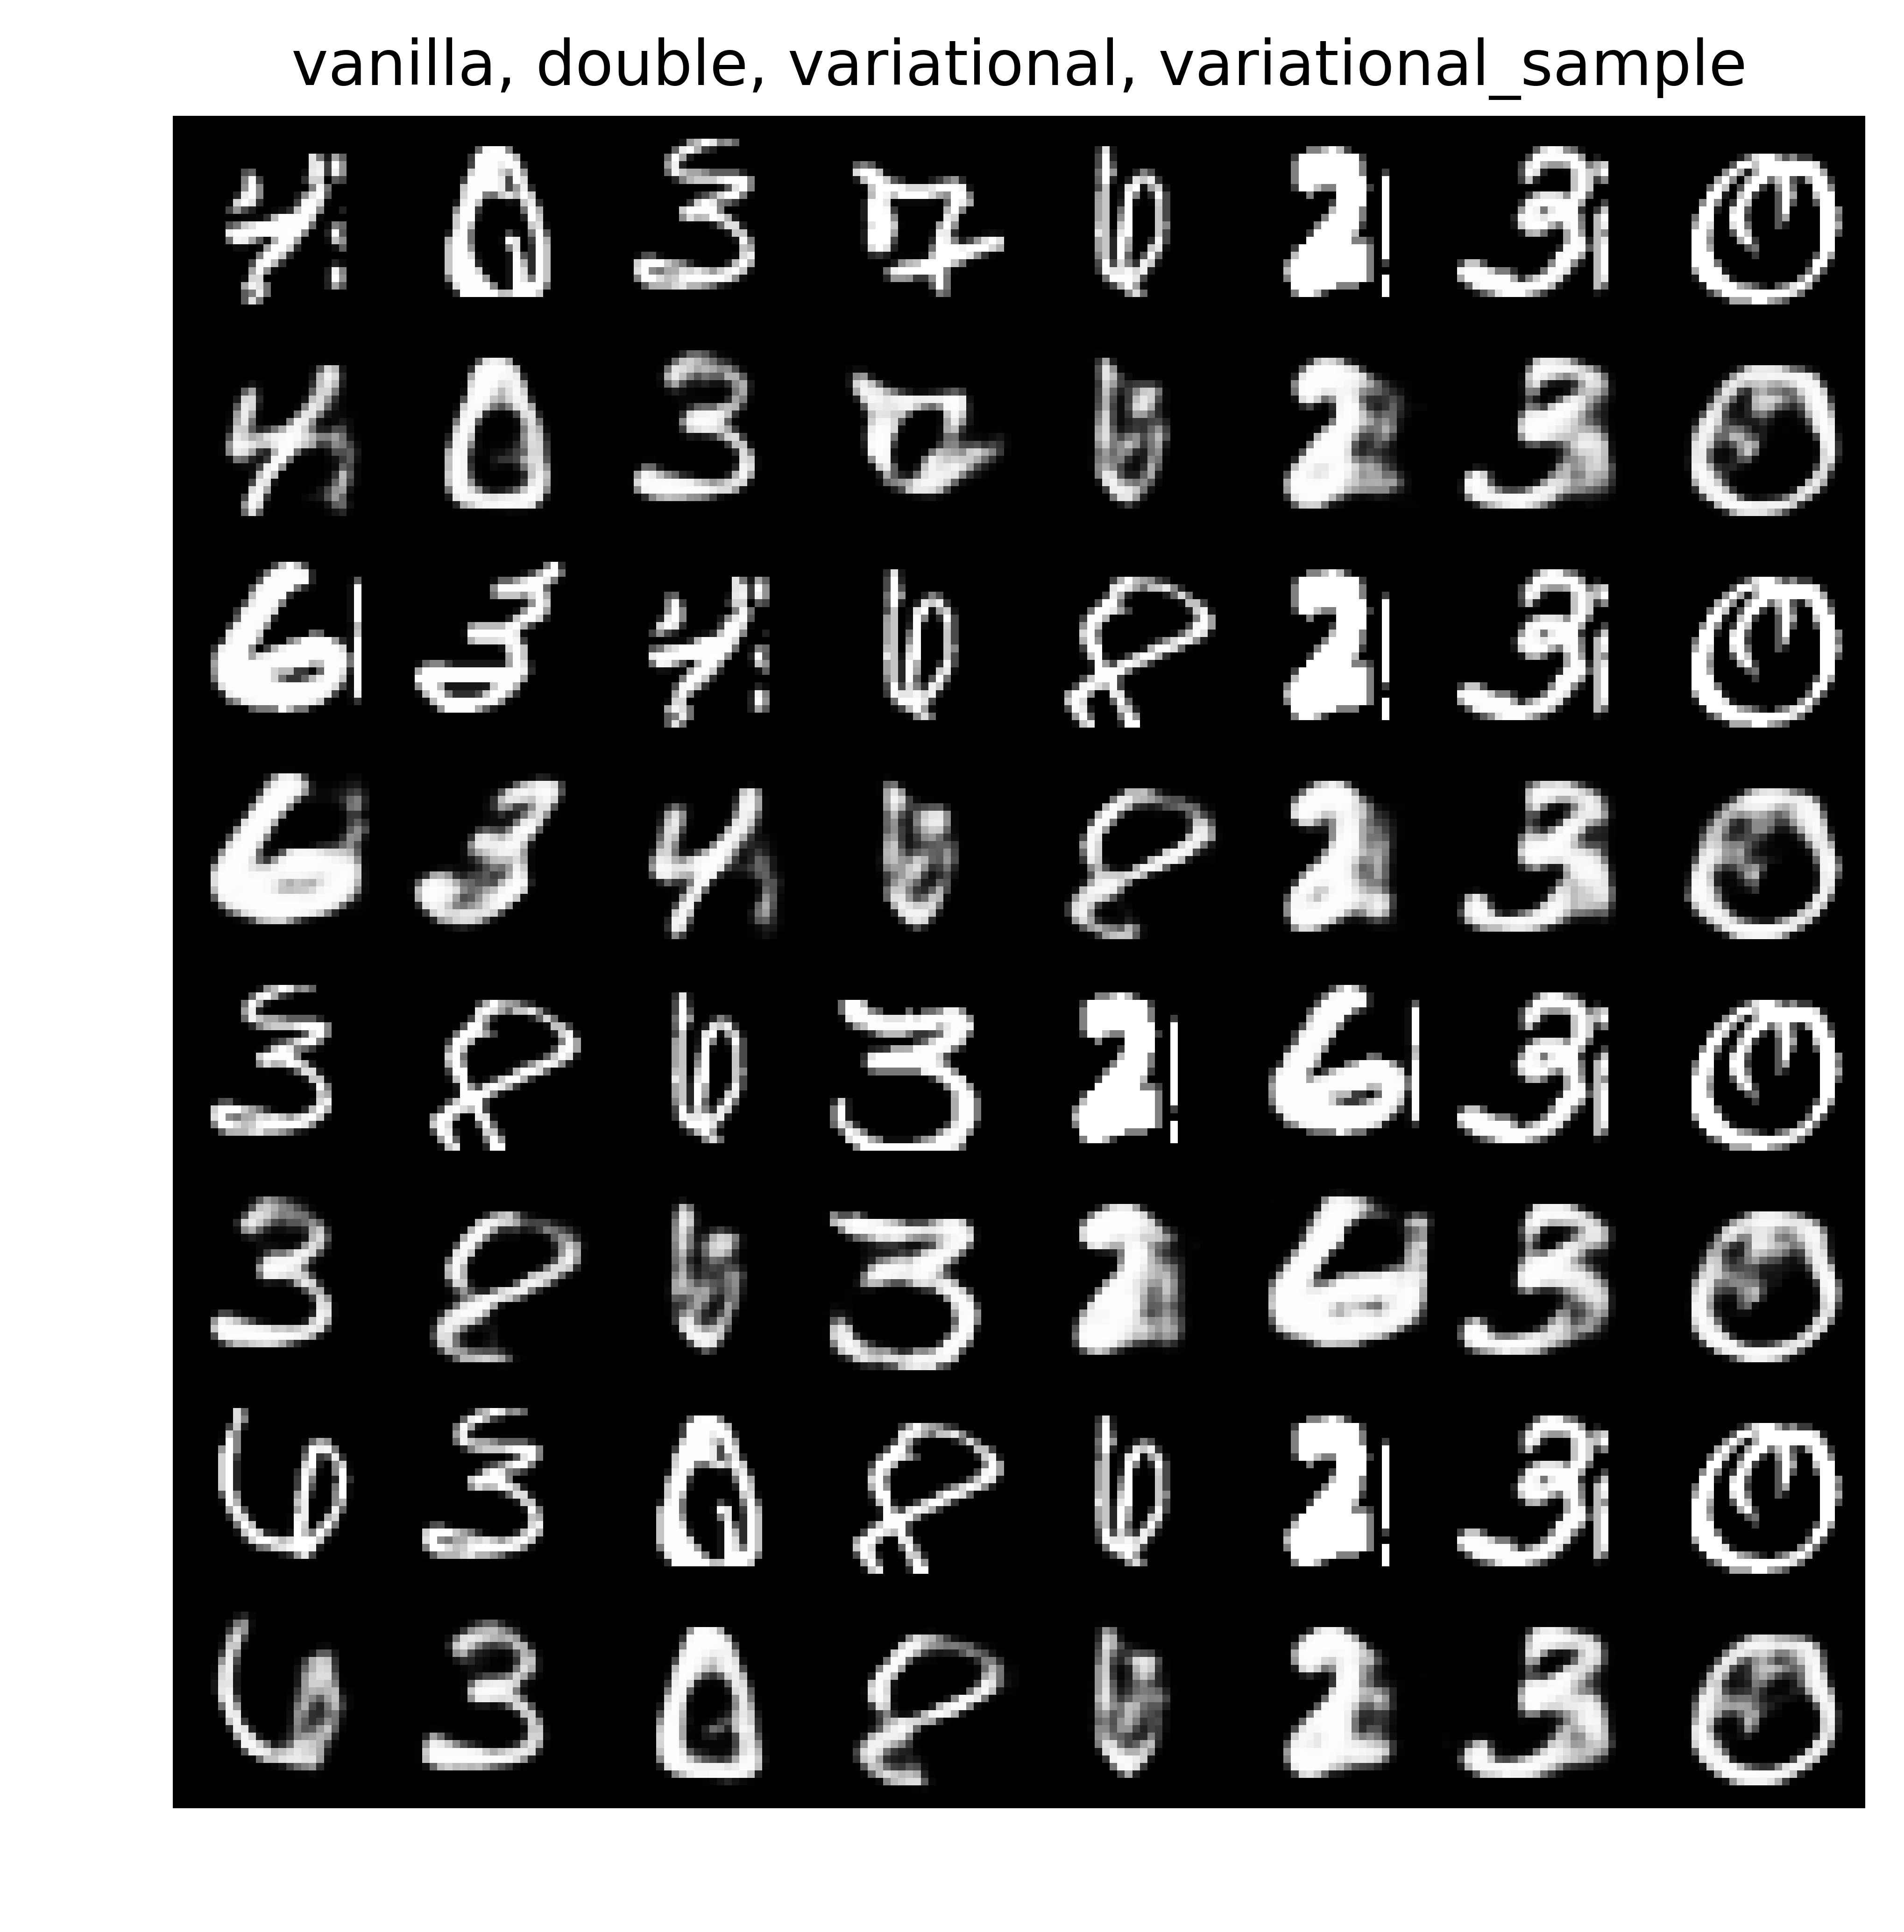

In [64]:
plt.clf()
plt.rcParams['figure.figsize'] = [8, 6]
plt.figure(dpi=800)
plt.title('vanilla, double, variational, variational_sample')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.axis('off')
plt.savefig('corrupted_and_denoised.png')

In [ ]:
here = '/home/ubuntu/deepsig'
model = 'variational'
n = 30
digit_size = x_test.shape[1]
figure = numpy.zeros((digit_size * n, digit_size * n))

filepath = os.path.join(here, model)
os.makedirs(filepath, exist_ok=True)
filename = os.path.join(filepath, "digits_over_latent.png")
# display a 30x30 2D manifold of digits
digit_size = x_test.shape[1]
figure = numpy.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = numpy.linspace(-4, 4, n)
grid_y = numpy.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = numpy.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(x_train.shape[1:])
        if digit.ndim == 3:
            digit = digit.mean(2)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = numpy.arange(start_range, end_range, digit_size)
sample_range_x = numpy.round(grid_x, 1)
sample_range_y = numpy.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.savefig(filename)
plt.show()